In [1]:
import boto3
import rasterio
from rasterio.merge import merge
from rasterio.plot import show
import geopandas as gpd
from shapely.geometry import box
from rasterio.crs import CRS
from rasterio.warp import transform_bounds
from rasterio.warp import calculate_default_transform, reproject, Resampling
import rioxarray
import xarray
from rioxarray.merge import merge_arrays

In [2]:
bucket_name = 'opera-pst-rs-pop1'

In [3]:
session = boto3.session.Session(profile_name='saml-pub')
s3 = session.resource('s3')
s3_client = session.client('s3')

In [4]:
bucket = s3.Bucket(bucket_name)

In [5]:
with open('dswx_manifest.txt') as f:
    lines = f.readlines()

print(lines[0])

s3://opera-pst-rs-pop1/products/OPERA_L3_DSWx_HLS_T01GDM_20220101T214749Z_20221125T202742Z_S2B_30_v0.0/



In [6]:
keys = []
for line in lines:
    prefix = line.split(bucket_name+'/')[-1][:-2]
    filename = prefix.split('/')[-1]+'_B01_WTR.tiff'
    keys.append(prefix+'/'+filename)
#print(keys[25000])
#s3_path = f'https://{bucket_name}.s3.us-west-2.amazonaws.com/{keys[25000]}'
#with rasterio.open(s3_path) as ds:
#    show(ds)
print(keys[0])

products/OPERA_L3_DSWx_HLS_T01GDM_20220101T214749Z_20221125T202742Z_S2B_30_v0.0/OPERA_L3_DSWx_HLS_T01GDM_20220101T214749Z_20221125T202742Z_S2B_30_v0.0_B01_WTR.tiff


In [7]:
basin_gdf = gpd.read_file('./hybas_af/hybas_af_lev02_v1c.shp')
basin_gdf.head()

,HYBAS_ID,NEXT_DOWN,NEXT_SINK,MAIN_BAS,DIST_SINK,DIST_MAIN,SUB_AREA,UP_AREA,PFAF_ID,ENDO,COAST,ORDER,SORT,geometry
0,1020000010,0,1020000010,1020000010,0.0,0.0,3258330.6,3258330.6,11,0,1,0,1,"MULTIPOLYGON (((33.67778 27.62917, 33.67119 27..."
1,1020011530,0,1020011530,1020011530,0.0,0.0,4660080.9,4660080.9,12,0,1,0,2,"MULTIPOLYGON (((34.80278 -19.81667, 34.79279 -..."
2,1020018110,0,1020018110,1020018110,0.0,0.0,4900405.1,4900405.1,13,0,1,0,3,"MULTIPOLYGON (((5.64444 -1.47083, 5.62972 -1.4..."
3,1020021940,0,1020021940,1020021940,0.0,0.0,4046600.5,4046600.5,14,0,1,0,4,"MULTIPOLYGON (((0.97778 5.98750, 0.97022 5.988..."
4,1020027430,0,1020027430,1020027430,0.0,0.0,6923559.6,6923559.6,15,0,1,0,5,"MULTIPOLYGON (((23.28611 32.22083, 23.28133 32..."


In [8]:
mrg_gdf = gpd.read_file('./world_mgrs/mgrs_region.shp') 
mrg_gdf.head()

,GRID1MIL,GRID100K,LONGITUDE,LATITUDE,geometry
0,33L,SC,12.102867,-15.678288,"POLYGON ((12.00000 -16.00000, 12.00000 -15.909..."
1,33L,TC,12.666855,-15.679626,"POLYGON ((13.13098 -16.00000, 13.12500 -16.000..."
2,33L,UC,13.599601,-15.684492,"POLYGON ((14.06538 -16.00000, 14.06250 -16.000..."
3,33L,VC,14.532691,-15.687415,"POLYGON ((15.00000 -16.00000, 14.90625 -16.000..."
4,33L,WC,15.467309,-15.687415,"POLYGON ((15.93462 -16.00000, 15.84375 -16.000..."


<AxesSubplot: >

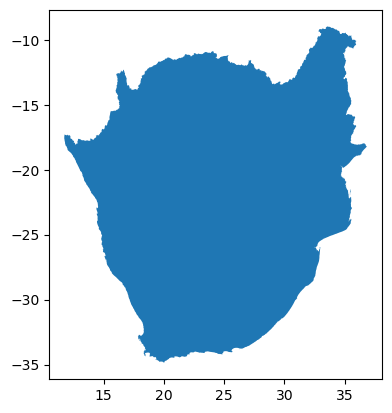

In [9]:
target_basin =  basin_gdf[basin_gdf.PFAF_ID==12]
target_basin.plot()

<AxesSubplot: >

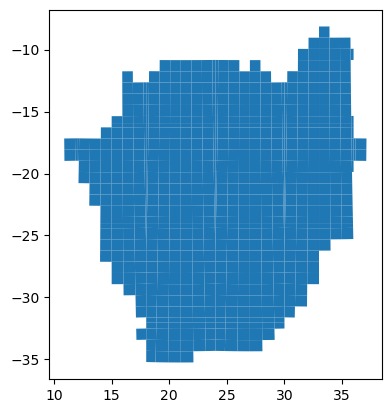

In [10]:
grid_codes = gpd.sjoin(mrg_gdf,target_basin)
grid_codes.plot()

In [11]:
tile_list = []
for row in grid_codes.iterrows():
    tile_list.append(row[1].iloc[0]+row[1].iloc[1])
len(tile_list)

688

In [12]:
keys = []
for line in lines:
    prefix = line.split(bucket_name+'/')[-1][:-2]
    filename = prefix.split('/')[-1]+'_B01_WTR.tiff'
    tile = filename.split('_')[4][1:]
    if tile in tile_list:
        keys.append(prefix+'/'+filename)
print(keys[0])
print(len(keys))

products/OPERA_L3_DSWx_HLS_T32KQE_20220102T090259Z_20221126T045427Z_S2B_30_v0.0/OPERA_L3_DSWx_HLS_T32KQE_20220102T090259Z_20221126T045427Z_S2B_30_v0.0_B01_WTR.tiff
1996


In [13]:
'''
metadata = {
    'geometry':[],
    's3_path':[],
    }
for key in keys:
    s3_path = f'https://{bucket_name}.s3.us-west-2.amazonaws.com/{key}'
    with rasterio.open(s3_path) as ds:
        bounds = ds.bounds
        crs_utm = ds.crs
        
    bounds_4326 = transform_bounds(crs_utm, CRS.from_epsg(4326), *bounds)
    geometry = box(*bounds_4326)

    metadata['geometry'].append(geometry)
    metadata['s3_path'].append(s3_path)
gdf = gpd.GeoDataFrame(metadata)
gdf.head()
'''

"\nmetadata = {\n    'geometry':[],\n    's3_path':[],\n    }\nfor key in keys:\n    s3_path = f'https://{bucket_name}.s3.us-west-2.amazonaws.com/{key}'\n    with rasterio.open(s3_path) as ds:\n        bounds = ds.bounds\n        crs_utm = ds.crs\n        \n    bounds_4326 = transform_bounds(crs_utm, CRS.from_epsg(4326), *bounds)\n    geometry = box(*bounds_4326)\n\n    metadata['geometry'].append(geometry)\n    metadata['s3_path'].append(s3_path)\ngdf = gpd.GeoDataFrame(metadata)\ngdf.head()\n"

In [18]:
i = 0
for key in keys:
    s3_path = f'https://{bucket_name}.s3.us-west-2.amazonaws.com/{key}'
    with rioxarray.open_rasterio(s3_path) as xds:
        reproj = xds.rio.reproject("EPSG:4326")
        if i == 0:
            merged_raster = reproj
        else:
            merged_raster = merge_arrays(dataarrays = [merged_raster,reproj], crs="EPSG:4326", nodata = 255)
        #ds_to_mosaic.append(reproj)
    if i%100 == 0:
        print(f'Finshed loading {i} tiles')
    i = i+1
#ds_to_mosaic[0]

Finshed loading 0 tiles


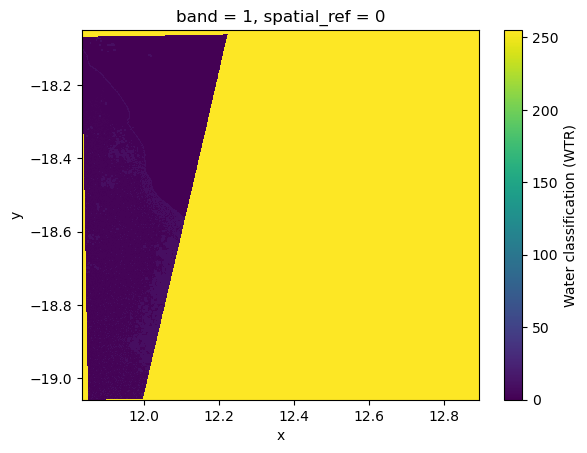

In [19]:
#merged_raster.plot()

In [ ]:
ds_to_mosaic = []
i = 0
for key in keys[]:
    s3_path = f'https://{bucket_name}.s3.us-west-2.amazonaws.com/{key}'
    xds = rioxarray.open_rasterio(s3_path)
    reproj = xds.rio.reproject("EPSG:4326")
    ds_to_mosaic.append(reproj)
    if i%100 == 0:
        print(f'Finshed loading {i} tiles')
    i = i+1
ds_to_mosaic[0]

In [ ]:
len(ds_to_mosaic)

In [ ]:
merged_raster =  merge_arrays(dataarrays = ds_to_mosaic, crs="EPSG:4326", nodata = 255)
#merged_raster.plot()

In [ ]:
merged_raster.rio.to_raster('test_mosaic_xarray3.tif')

In [ ]:
src_files_to_mosaic = []
i = 0
for key in keys:
    s3_path = f'https://{bucket_name}.s3.us-west-2.amazonaws.com/{key}'
    src = rasterio.open(s3_path)
    src_files_to_mosaic.append(src)
    if i%100 == 0:
        print(f'Finshed loading {i} tiles')
    i = i+1

In [ ]:
dst_crs = 'EPSG:4326'
src_files_reproject = []
i = 0
for src in src_files_to_mosaic:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })
    dst = reproject(
            source=src,
            #src_transform=src.transform,
            src_crs=src.crs,
            #dst_transform=transform,
            dst_crs=dst_crs,
            #resampling=Resampling.nearest
    )
    src_files_reproject.append(dst)
    if i%100 == 0:
        print(f'Finshed loading {i} tiles')
    i =  i+1

In [ ]:
mosaic, out_trans = merge(src_files_to_mosaic)

In [ ]:
show(mosaic)

In [ ]:
src_files_to_mosaic[410].crs

In [ ]:
out_meta = src.meta.copy()
out_meta.update({"ddriver": "GTiff",
    "heighht": mosaic.shape[1],
    "width": mosaic.shape[2],
    "transform": out_trans,
    "crs": "epsg:4326"
})
with rasterio.open('test_mosaic.tif',"w",**out_meta) as dest:
    dest.write(mosaic)